In [74]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [116]:
start = dt.datetime(2020,1,1)
end = dt.datetime(2024,5,31)

eth = yf.download('ETH-USD', start, end)
# eth.reset_index(inplace = True)
eth_use = eth[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [117]:
eth_use.rename(columns = {'Close': 'ETH'}, inplace = True)

<ipython-input-117-3cfdbf3cebc2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_use.rename(columns = {'Close': 'ETH'}, inplace = True)


# ARIMA

In [118]:
eth_use.reset_index(inplace = True)

In [119]:
eth_use['Date'] = eth_use['Date'].dt.date
eth_use.set_index(pd.to_datetime(eth_use['Date']), inplace = True)
eth_use.drop('Date', axis=1, inplace = True)
eth_use.head()

<ipython-input-119-fd51387c1d5b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_use['Date'] = eth_use['Date'].dt.date
<ipython-input-119-fd51387c1d5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_use.drop('Date', axis=1, inplace = True)


,ETH
Date,
2020-01-01,130.802002
2020-01-02,127.410179
2020-01-03,134.171707
2020-01-04,135.069366
2020-01-05,136.276779


<Axes: xlabel='Date'>

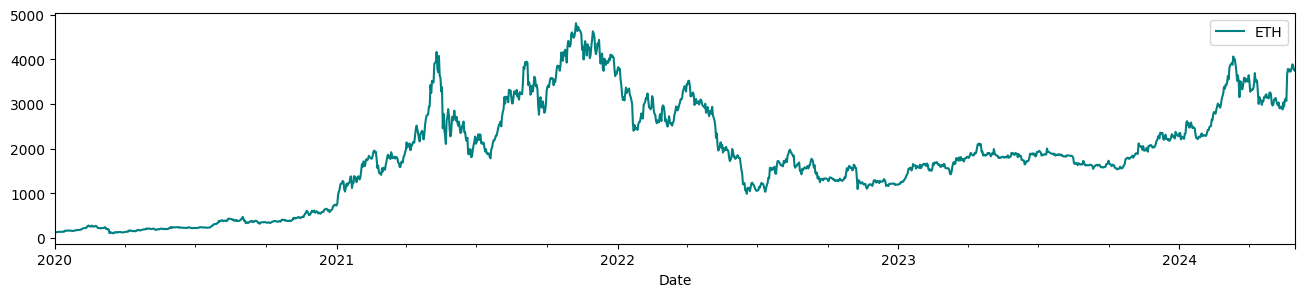

In [120]:
eth_use.plot(y='ETH', color='teal', figsize=(16,3))

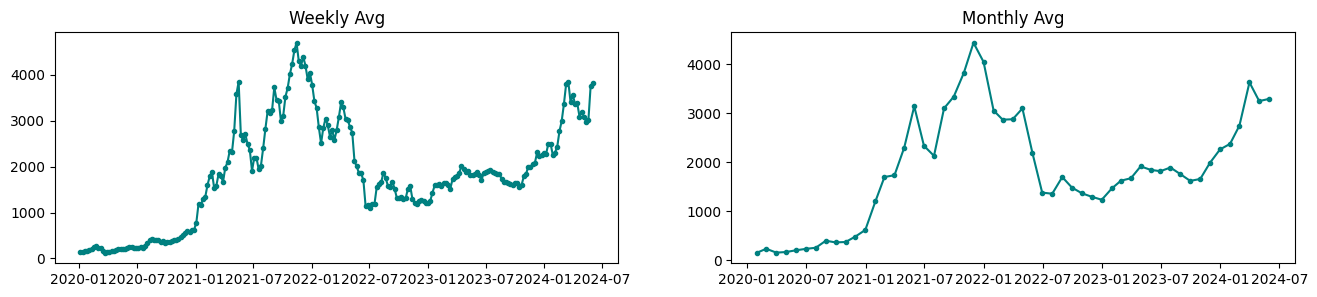

In [121]:

price_weekly_avg = eth_use.resample('W').apply(np.mean)
price_monthly_avg = eth_use.resample('M').apply(np.mean)
plt.figure(figsize=(16,3))
plt.subplot(121)
plt.title('Weekly Avg')
plt.plot(price_weekly_avg.ETH, "-o", markersize=3, color='teal')
plt.subplot(122)
plt.title('Monthly Avg')
plt.plot(price_monthly_avg.ETH, "-o", markersize=3, color='teal')

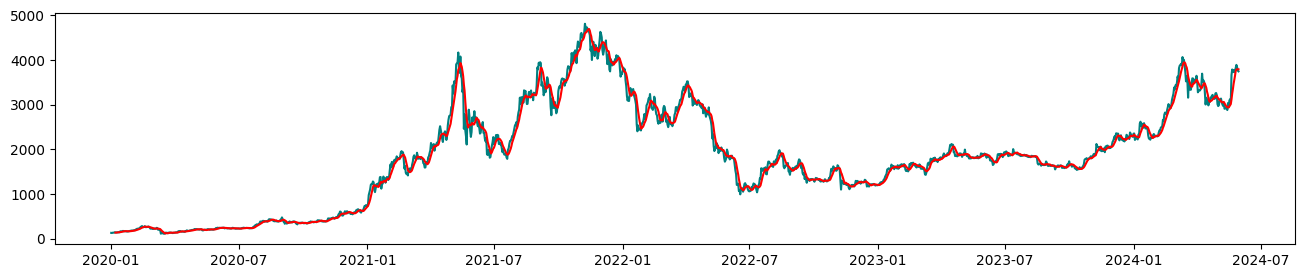

In [122]:

rolling_mean = eth_use.ETH.rolling(window=7, center=False).mean() #window of 7 (weekly avg) captures our data better
plt.figure(figsize=(16,3))
plt.plot(eth_use.ETH, color='teal')
plt.plot(rolling_mean, 'red')

### Make data stationary and check autocorrelation
- stationary is prerequisite for most models
- means taking trend out of it (de-trending the data) in order to have its statistical properties (i.e. mean, variance) constant over time.
- Will help sample to be more predictable by model since can be assumed that statistical properties of data will be same in the future as they were in the past.
- Use differencing, taking difference of two data points within specified period (lag).
- Use autocorrelation method to get optimal lag.
- Autocorrelation measures correlation (similarity) between time series and a lagged version of itself.

Text(0, 0.5, 'Autocorrelation')

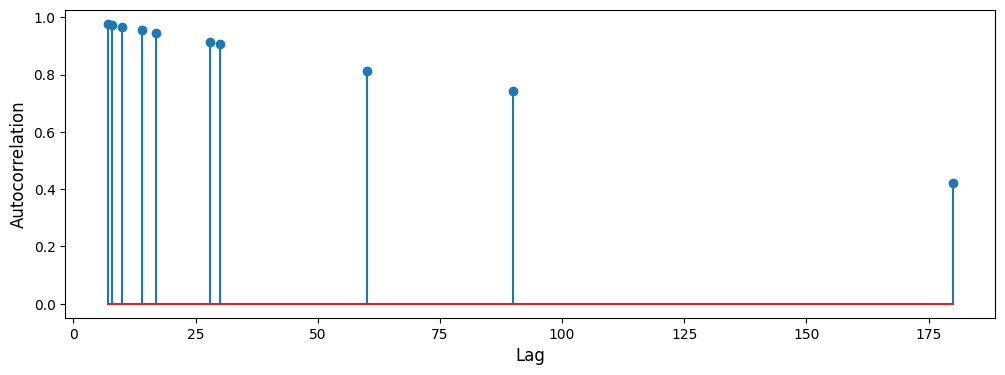

In [123]:
lags = [7, 8, 10, 14, 17, 28, 30, 60, 90, 180]
autocorrs = [eth_use.ETH.autocorr(lag=lag)
                   for lag in lags]
plt.figure(figsize=(12, 4))
plt.stem(lags, autocorrs)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("Autocorrelation", fontsize=12)

Based on above graph, highest correlation occurs at lag of 7, means data repeats pattern on a weekly basis.

Can also check autocorrelation through pandas.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

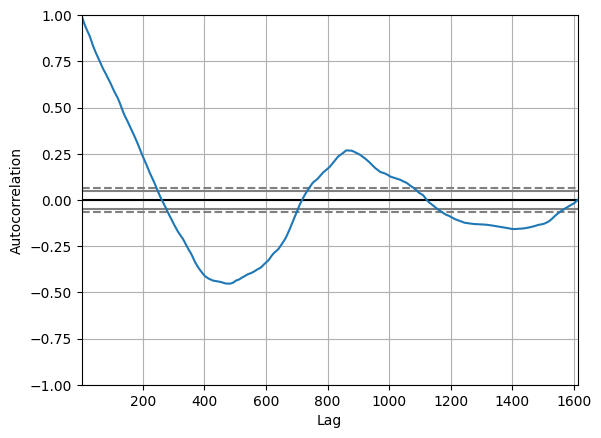

In [124]:

from pandas.plotting import autocorrelation_plot

autocorrelation_plot(eth_use)

Can conclude lag of 7 is a good candidate for optimal lag.

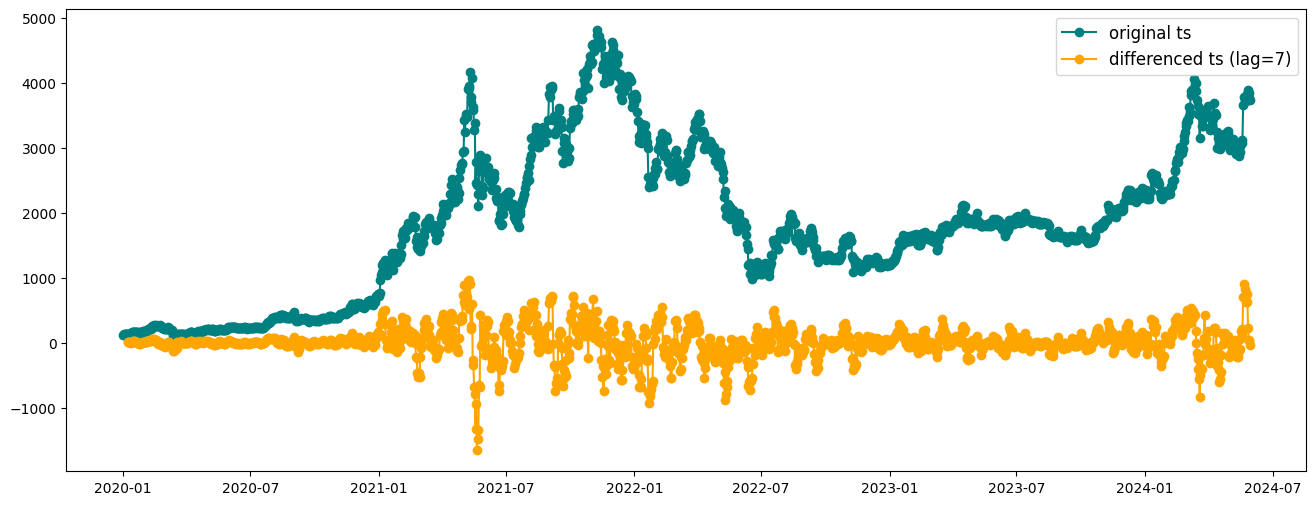

In [125]:
plt.figure(figsize=(16, 6))
plt.plot(eth_use.ETH, '-o', color='teal', label="original ts")
plt.plot(eth_use.ETH.diff(7), '-o', color='orange', label="differenced ts (lag=7)")
plt.legend(fontsize=12)

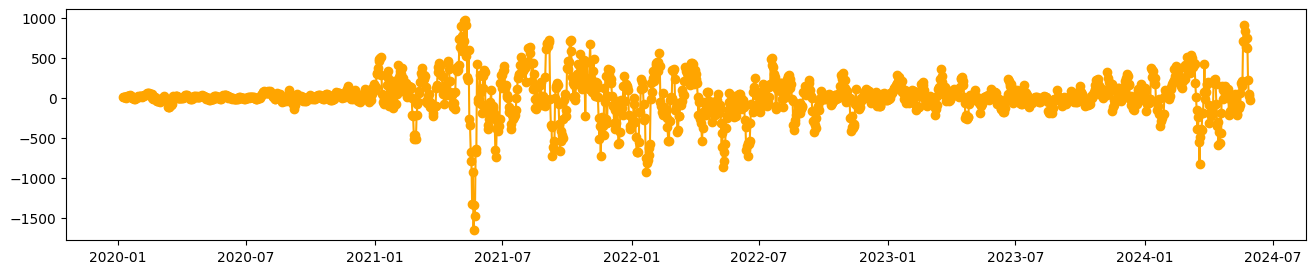

In [131]:
prices = eth_use.ETH
price_diff = prices.diff(7)

plt.figure(figsize=(16,3))
plt.plot(price_diff, "-o", color='orange')

In [132]:
time_series = price_diff

# ARIMA Model

The difference between ARMA and AR is that the latter models a point in the time series as a linear model of the previous values, and treats the error between the actual data and the predictions as noise. But what if there could still be information in the series of errors? ARMA on the other hand includes the past errors as additional features to the model and is defined as ARMA(p,q).

Just as the name suggests ARMA is comprised of two models, AR(p) (just like above) and MA(q) which is the moving average part and q defines the number of moving average terms.
Let's now run the model with p=7 and q=7 and see the results. You should also play around with these two variables and see the different results that they produce.

In [133]:
time_series.shape

(1612,)

In [134]:
arima_prediction.shape

(1505,)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAE = 58.294
MAE2 = 89.279


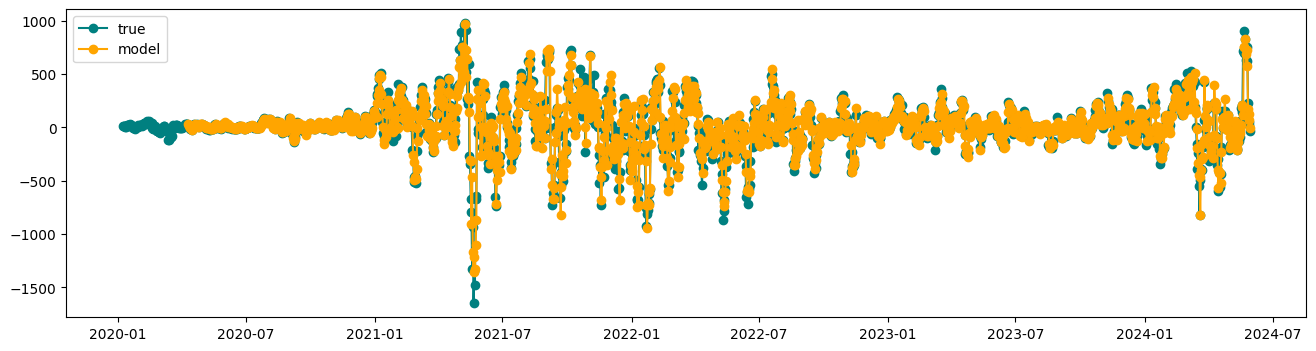

In [198]:
# arma = tsa.ARMA(time_series, order=(7, 7)) #7 p and 7 q for lag and moving average
model = sm.tsa.arima.ARIMA(time_series, order=(7,0,7))
arima_fit = model.fit()
start=100
arima_prediction = arima_fit.predict(start=start)

plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label='true', color='teal')
plt.plot(arima_prediction, '-o', label='model', color='orange')
plt.legend();

print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[start:], arima_prediction)))
print('MAE2 = {0:.3f}'.format(mean_absolute_error(time_series[-90:], arima_prediction[-90:]))) #error only for the last 90 days

In [199]:
arima_forecast= arima_fit.forecast(steps=7)
arima_forecast

2024-05-31     -8.025614
2024-06-01    -26.807887
2024-06-02    -92.373869
2024-06-03   -154.969308
2024-06-04   -129.071057
2024-06-05    -36.535021
2024-06-06    -18.953170
Freq: D, Name: predicted_mean, dtype: float64

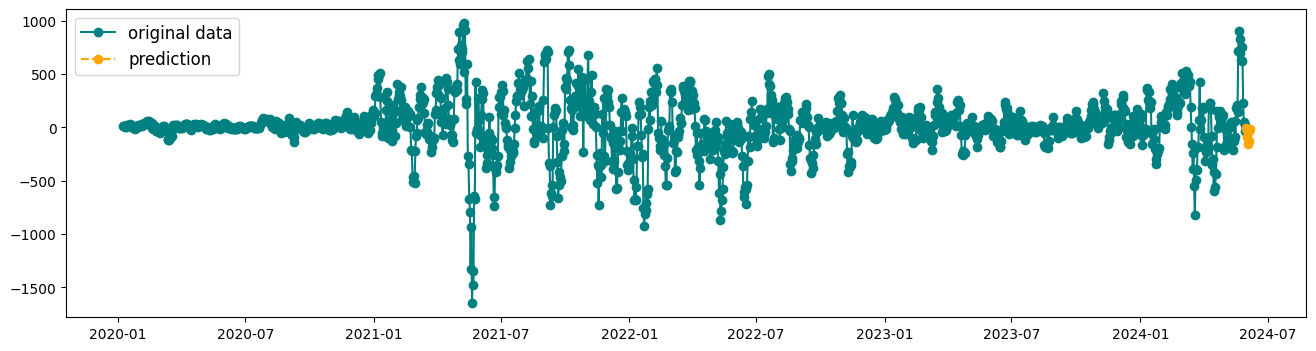

In [200]:
#ARMA model's 7 out sample predicitons
plt.figure(figsize=(16, 4))
plt.plot(time_series, '-o', label="original data", color='teal')
plt.plot(arima_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

The predicted values aren't the actual future prices but the differenced values. In order to find actual future prices, we need to reverse the process and change series from stationary to the original form.
- Add each predicted value to the actual value 7 days before that. Last 7 days value in the original series were:

In [201]:
print(eth_use[-7:])

                    ETH
Date                   
2024-05-24  3726.934570
2024-05-25  3749.236572
2024-05-26  3825.897461
2024-05-27  3892.006836
2024-05-28  3840.256348
2024-05-29  3763.196533
2024-05-30  3746.849609


In [202]:
idx = arima_forecast.index.values

forecast_prices = []
lag = 7
for i, diff in enumerate(arima_forecast):
  prev_value = prices[-(lag)+i:][0]
  forecast_prices.append(prev_value+diff)

eth_forecast = pd.DataFrame(forecast_prices, index = idx)
eth_forecast.rename(columns = {0: 'ETH'}, inplace = True)
eth_forecast.index.name = 'Date'

In [203]:
# eth_forecast
eth_use

,ETH
Date,
2020-01-01,130.802002
2020-01-02,127.410179
2020-01-03,134.171707
2020-01-04,135.069366
2020-01-05,136.276779
...,...
2024-05-26,3825.897461
2024-05-27,3892.006836
2024-05-28,3840.256348


In [204]:
eth_forecast

,ETH
Date,
2024-05-31,3718.908957
2024-06-01,3722.428685
2024-06-02,3733.523592
2024-06-03,3737.037528
2024-06-04,3711.185290
2024-06-05,3726.661512
2024-06-06,3727.896439


In [205]:
hist_values = pd.concat([eth_use, eth_forecast])

In [206]:
hist_values

,ETH
Date,
2020-01-01,130.802002
2020-01-02,127.410179
2020-01-03,134.171707
2020-01-04,135.069366
2020-01-05,136.276779
...,...
2024-06-02,3733.523592
2024-06-03,3737.037528
2024-06-04,3711.185290


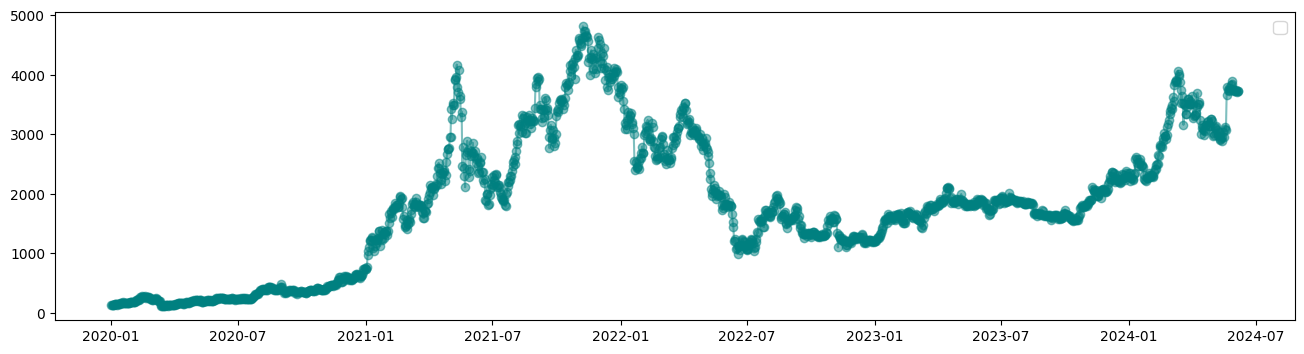

In [207]:
# hist_values = eth_use.append(eth_forecast)
hist_values = pd.concat([eth_use, eth_forecast])

# plt.figure(fig=(16,4))
# plt.plot(hist_values, '-o', color='teal', alpha=0.5)
# plt.show
plt.figure(figsize=(16, 4))
plt.plot(hist_values, '-o', color='teal', alpha = 0.5)
# plt.plot(arima_forecast, '--o', label='prediction', color='orange')
plt.legend(fontsize=12)

In [208]:
start = dt.datetime(2024,5,31)
end = dt.datetime(2024,6,7)

eth_real = yf.download('ETH-USD', start, end)
# eth.reset_index(inplace = True)
# eth_use = eth[['Close']]
real_price = eth_real[['Close']]

[*********************100%%**********************]  1 of 1 completed


In [209]:
real_price.rename(columns = {'Close': 'ETH'}, inplace = True)
real_price

<ipython-input-209-b9cfa03b7dea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_price.rename(columns = {'Close': 'ETH'}, inplace = True)


,ETH
Date,
2024-05-31,3760.026611
2024-06-01,3813.198975
2024-06-02,3780.895996
2024-06-03,3766.389160
2024-06-04,3812.515869
2024-06-05,3864.260986
2024-06-06,3811.605957


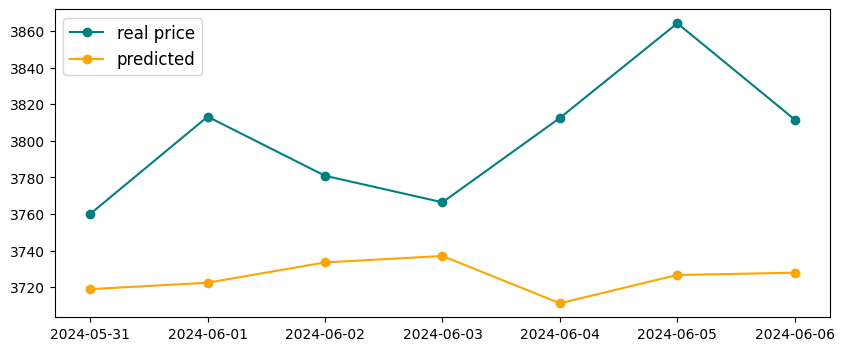

In [210]:
plt.figure(figsize=(10,4))
plt.plot(real_price, "-o", color="teal", label="real price")
plt.plot(eth_forecast, "-o", color="orange", label="predicted")
plt.legend(fontsize=12)
plt.show()